In [59]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import data, cast, image, float32, function, random, newaxis, argmax
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, ReLU, Layer, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import preprocessing as kp

In [50]:
def sample(filters: int) -> Layer:
    layer = Sequential([Conv2D(filters=filters, kernel_size=(3, 3), padding="same"),
                        BatchNormalization(),
                        ReLU(),
                        Conv2D(filters=filters, kernel_size=(3, 3), padding="same"),
                        BatchNormalization(),
                        ReLU(), ])
    return layer


class UNET:
    def __init__(self, *, classes: int, input_shape: tuple,
                 layers_filters: list[int] = None):
        self._input_shape = input_shape
        self._down_layers = []
        self._up_layers = []
        if layers_filters is None:
            layers_filters = [64, 128, 256, 512]
        for f in layers_filters:
            self._down_layers.append(sample(f))
            self._down_layers.append(MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
            self._up_layers.append(sample(f))
            self._up_layers.append(Conv2DTranspose(filters=f, kernel_size=(2, 2), strides=2, padding="same"))
        self._up_layers.reverse()
        self._last_layer = sample(layers_filters[-1] * 2)
        self._final_output_layer = Conv2D(filters=classes, kernel_size=(1, 1))

    def get_unet(self):
        x = Input(shape=self._input_shape)
        skip_connection = []
        y = self._down_layers[0](x)
        skip_connection.append(y)
        for num, down_layer in enumerate(self._down_layers[1:]):
            y = down_layer(y)
            if num % 2 == 1:
                skip_connection.append(y)
        y = self._last_layer(y)
        for up_num in range(0, len(self._up_layers), 2):
            y = self._up_layers[up_num](y)
            y = self._up_layers[up_num + 1](concatenate([skip_connection.pop(), y], axis=-1))
        y = self._final_output_layer(y)
        return Model(inputs=x, outputs=y)

In [51]:
unet = UNET(classes=3, input_shape=(128, 128, 3), layers_filters=[32, 64, 128]).get_unet()
# u.build(input_shape=(None, 518, 518, 3))
unet.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_143 (Sequential)     (None, 128, 128, 32) 10400       input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_63 (MaxPooling2D) (None, 64, 64, 32)   0           sequential_143[0][0]             
__________________________________________________________________________________________________
sequential_145 (Sequential)     (None, 64, 64, 64)   55936       max_pooling2d_63[0][0]           
____________________________________________________________________________________________

In [52]:
opt = SGD(learning_rate=0.001, momentum=0.99, nesterov=True)
unet.compile(optimizer=opt, loss=SparseCategoricalCrossentropy(from_logits=True),
             metrics=['acc'])

In [53]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, download=False)
def normalize(input_image, input_mask):
    """
    图像标准化到 [0,1]。最后，如上文提到的，像素点在图像分割掩码中被标记为 {1, 2, 3} 中的一个。为了方便起见，我们将分割掩码都减 1，得到了以下的标签：{0, 1, 2}

    :param input_image:
    :param input_mask:
    :return:
    """
    input_image = cast(input_image, float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@function
def load_image_train(datapoint: data.Dataset):
    """
    进行了一个简单的图像翻转扩充
    :param datapoint:
    :return:
    """
    input_image = image.resize(datapoint['image'], (128, 128))
    input_mask = image.resize(datapoint['segmentation_mask'], (128, 128))

    if random.uniform(()) > 0.5:
        input_image = image.flip_left_right(input_image)
        input_mask = image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint: data.Dataset):
    input_image = image.resize(datapoint['image'], (128, 128))
    input_mask = image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train = dataset['train'].map(load_image_train, num_parallel_calls=data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(64)
train_dataset = train_dataset.prefetch(buffer_size=data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [54]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(kp.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [55]:
history = unet.fit(train_dataset, epochs=50, validation_data=test_dataset, verbose=1)

Epoch 1/50
58/58 [==============================] - 36s 580ms/step - loss: 1.0113 - acc: 0.4934 - val_loss: 0.9363 - val_acc: 0.5731
Epoch 2/50
58/58 [==============================] - 33s 572ms/step - loss: 0.8628 - acc: 0.5888 - val_loss: 0.9079 - val_acc: 0.5696
Epoch 3/50
58/58 [==============================] - 33s 573ms/step - loss: 0.8208 - acc: 0.6049 - val_loss: 0.8895 - val_acc: 0.5730
Epoch 4/50
58/58 [==============================] - 34s 584ms/step - loss: 0.7641 - acc: 0.6417 - val_loss: 0.8407 - val_acc: 0.5934
Epoch 5/50
58/58 [==============================] - 34s 583ms/step - loss: 0.7002 - acc: 0.6906 - val_loss: 1.0662 - val_acc: 0.5216
Epoch 6/50
58/58 [==============================] - 33s 576ms/step - loss: 0.6444 - acc: 0.7260 - val_loss: 1.6515 - val_acc: 0.5499
Epoch 7/50
58/58 [==============================] - 33s 576ms/step - loss: 0.5971 - acc: 0.7529 - val_loss: 1.8390 - val_acc: 0.5743
Epoch 8/50
58/58 [==============================] - 33s 578ms/step - 

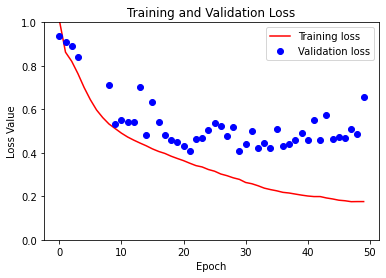

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(50)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

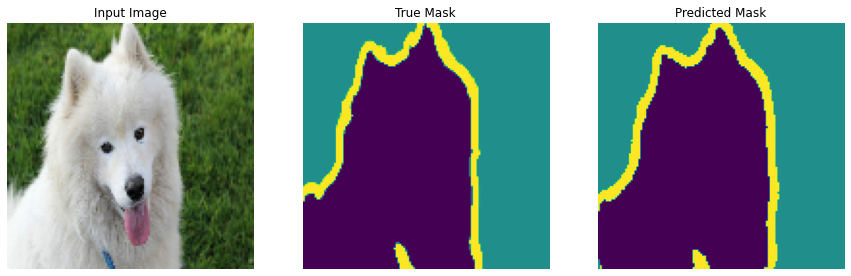

In [69]:
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image[11], mask[11]
    test_image = sample_image[newaxis, ...]
    p_mask = unet.predict(test_image)
    label_p = argmax(p_mask, axis=-1)
    label_p = label_p[..., newaxis]
    display([sample_image, sample_mask, label_p[0]])